In [14]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

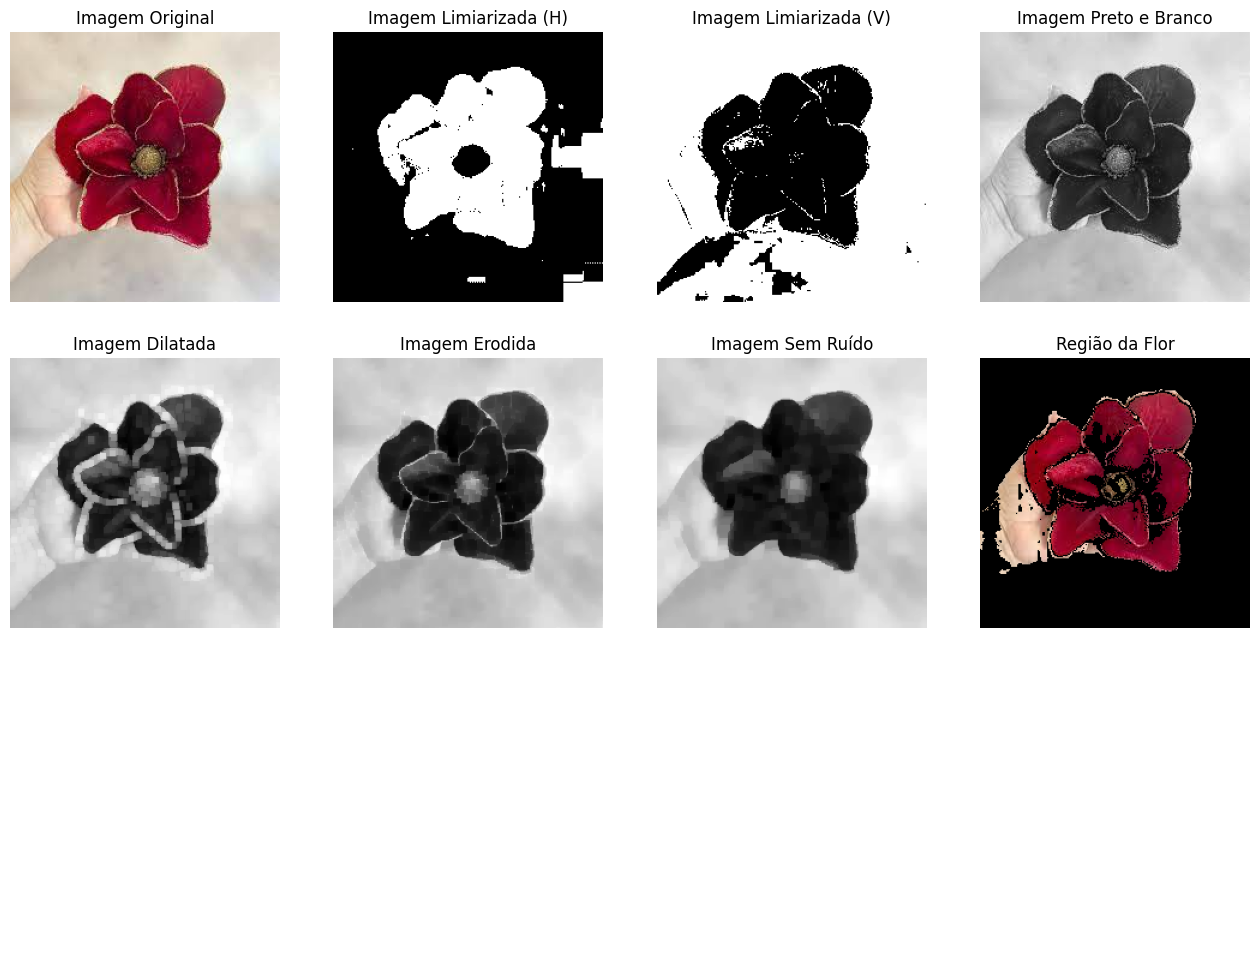

In [15]:
# Etapa 1: Converta a imagem do espaço de cores RGB para o espaço de cores HSV
image = cv2.imread('./images/magnolia.jpeg')
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Etapa 2: Separe os canais H (Matiz) e V (Valor)
h_channel = hsv_image[:,:,0]
v_channel = hsv_image[:,:,2]

# Etapa 3: Extraia o Contraste, Correlação, Energia e Homogeneidade da imagem H e V separadamente como Hstat e Vstat
h_eq_hist = cv2.equalizeHist(h_channel)
v_eq_hist = cv2.equalizeHist(v_channel)

h_contrast = np.sum((h_channel - h_eq_hist) ** 2)
v_contrast = np.sum((v_channel - v_eq_hist) ** 2)

h_hist = cv2.calcHist([h_channel], [0], None, [256], [0, 256])
v_hist = cv2.calcHist([v_channel], [0], None, [256], [0, 256])

h_homogeneity = np.sum(h_hist / (1 + np.abs(np.arange(256) - np.arange(256)[:, np.newaxis])))
v_homogeneity = np.sum(v_hist / (1 + np.abs(np.arange(256) - np.arange(256)[:, np.newaxis])))

h_energy = np.sum(h_channel ** 2)
v_energy = np.sum(v_channel ** 2)

# Etapa 4: Calcule a média de Hstat e Vstat como Hmean e Vmean, respectivamente
h_mean = np.mean(h_channel)
v_mean = np.mean(v_channel)

# Etapa 5: Determine a imagem de limiarização (H ou V) a partir dos recursos extraídos acima
_, h_thresholded = cv2.threshold(h_channel, h_mean, 255, cv2.THRESH_BINARY)
_, v_thresholded = cv2.threshold(v_channel, v_mean, 255, cv2.THRESH_BINARY)

# Etapa 6: Converta a imagem em imagem preto e branco (B/W)
bw_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Etapa 7: Aplique a operação morfológica de dilatação
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated_image = cv2.dilate(bw_image, kernel, iterations=1)

# Etapa 8: Aplique a operação morfológica de erosão
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)

# Etapa 9: Remova o ruído da imagem
denoised_image = cv2.morphologyEx(eroded_image, cv2.MORPH_OPEN, kernel)

# Definindo os intervalos de cores para as cores das flores
color_ranges = [
    ([20, 100, 100], [30, 255, 255]), # Amarelo
    ([5, 50, 50], [15, 255, 255]), # Laranja
    ([160, 100, 100], [179, 255, 255]), # Vermelho
    ([80, 100, 100], [100, 255, 255]) # Verde
]

# Criar uma máscara para cada intervalo de cores e combina-lás em uma única máscara
mask = np.zeros_like(hsv_image[:,:,0])
for lower, upper in color_ranges:
    lower = np.array(lower)
    upper = np.array(upper)
    color_mask = cv2.inRange(hsv_image, lower, upper)
    mask = cv2.bitwise_or(mask, color_mask)

# Aplicar a máscara na imagem original para extrair apenas as regiões das flores
flower_region = cv2.bitwise_and(image, image, mask=mask)

# Exibindo os resultados
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Imagem Original')



axs[0, 1].imshow(h_thresholded, cmap='gray')
axs[0, 1].set_title('Imagem Limiarizada (H)')

axs[0, 2].imshow(v_thresholded, cmap='gray')
axs[0, 2].set_title('Imagem Limiarizada (V)')

axs[0, 3].imshow(bw_image, cmap='gray')
axs[0, 3].set_title('Imagem Preto e Branco')

axs[1, 0].imshow(dilated_image, cmap='gray')
axs[1, 0].set_title('Imagem Dilatada')

axs[1, 1].imshow(eroded_image, cmap='gray')
axs[1, 1].set_title('Imagem Erodida')

axs[1, 2].imshow(denoised_image, cmap='gray')
axs[1, 2].set_title('Imagem Sem Ruído')

axs[1, 3].imshow(cv2.cvtColor(flower_region, cv2.COLOR_BGR2RGB))
axs[1, 3].set_title('Região da Flor')

for ax in axs.flat:
    ax.axis('off')

plt.show()
